# Inference to a KServe v1 Predictor

Let's deploy our fine tuned model via KServe using the [v1 API](https://kserve.github.io/website/latest/modelserving/data_plane/v1_protocol/).
A custom model server can be found [here](https://quay.io/repository/marcocaimi/kserve-diffusers) and its source code can be found [here](https://github.com/mcaimi/kserve-diffusers-demo)

In [27]:
!pip install -U pip
!pip install requests pillow
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 42.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 22.2.2
    Uninstalling pip-22.2.2:
      Successfully uninstalled pip-22.2.2


In [28]:
import base64
try:
    import requests
    from PIL import Image
    import io
except Exception as e:
    print(f"Caught Exception {e}")

### Setup

Change that following variable settings match your deployed model's *Inference endpoint*. for example: 

```
infer_endpoint = "https://sd-stable-diffusion.apps.cluster-xc4f6.sandbox942.opentlc.com"
```

In [107]:
# the inference endpoint exposed by the model server
# this actually is the entry point that openshift exposes to hide the containerized workload
# KServe is serverless actually
infer_endpoint = "https://sd-stable-diffusion.apps.cluster-88nbt.sandbox134.opentlc.com"

# this is the inference method exposed by the KServe Model Server
infer_url = f"{infer_endpoint}/v1/models/model:predict"

## Request Function

Build and submit the REST request to the model server. 

An example JSON payload:

```json
 // example payload:
 {
   "instances": [
     {
       "prompt": "photo of the beach",
       "negative_prompt": "ugly, deformed, bad anatomy",
       "num_inference_steps": 20,
       "width": 512,
       "height": 512,
       "guidance_scale": 7,
       // "seed": 772847624537827,
     }
   ]
 }
```

In [108]:
# define the call function
def rest_request(url, prompt,
                 negative_prompt="",
                 steps=10,
                 width=512, height=512,
                 cfg=7,
                 timeout=600,
                 tls_verify=False):
    # prepare payload
    json_data = {
        "instances": [
            {
                "prompt": prompt,
                "negative_prompt": negative_prompt,
                "num_inference_steps": steps,
                "width": width,
                "height": height,
                "guidance_scale": cfg,
            }
        ]
    }

    # call the inference service
    response = requests.post(url, json=json_data, verify=tls_verify, timeout=timeout)

    # extract the resoponse payload
    response_dict = response.json()
    return response_dict

## Call the remote inference server

Let's call KServe to generate a RHTeddy image for us. Make sure the inference server has at least a GPU available otherwise this wwill most likey fail due to timeouts.

In [109]:
# prompt
prompt = "a photo of rhteddy dog wearing his red fedora on in the snowy mountains"

# call the service
json_response = rest_request(infer_url, prompt)

/opt/app-root/lib64/python3.9/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sd-stable-diffusion.apps.cluster-88nbt.sandbox134.opentlc.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [110]:
# now extract the image from the payload
# the image is base64 encoded
img_str = json_response["predictions"][0]["image"]["b64"]
img_data = base64.b64decode(img_str)

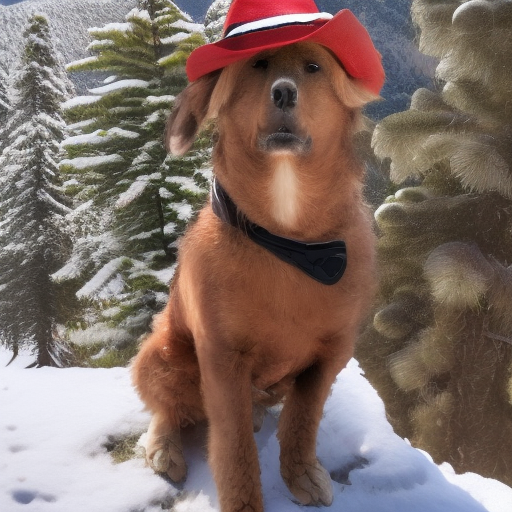

In [111]:
# convert the image back from base64 and display it
image = Image.open(io.BytesIO(img_data))
image.save("teddy.png", format="PNG")
image

## Build a Stable Diffusion UI with Gradio

Let's try to make our inference endpoint callable from a pretty web UI

In [112]:
# import the gradio toolkit
try:
    import gradio as gr
except Exception as e:
    print(f"Unable to import gradio library: {e}")

In [126]:
# build the callback function
def generate_image(url, prompt,
                 negative_prompt="",
                 steps=10,
                 width=512, height=512,
                 cfg=7,
                 timeout=600,
                 tls_verify=False):
    # call the generation function
    kserve_response = rest_request(url, prompt, negative_prompt=negative_prompt,
                                   steps=steps, width=width, height=height,
                                   cfg=cfg, timeout=timeout, tls_verify=tls_verify)

    # extract the payload
    image_payload = kserve_response.get("predictions")[0].get("image").get("b64")
    # decode from base64
    img_data = base64.b64decode(image_payload)

    # return image bytes
    return Image.open(io.BytesIO(img_data))

In [129]:
# build gradio application
sd_ui = gr.Interface(fn=generate_image,
                     inputs=[gr.Textbox(value=infer_url, label="Inference URL"),
                            gr.Textbox(label="Prompt"),
                            gr.Textbox(label="Negative Prompt"),
                            gr.Slider(label="Denoising Steps", value=5, minimum=1, maximum=100, step=1),
                            gr.Number(label="Width", value=512), gr.Number(label="Height", value=512),
                            gr.Slider(label="Guidance Scale", value=7, minimum=1, maximum=100, step=0.5)],
                     outputs=gr.Image())

# start the application
sd_ui.launch(share=True)

Running on local URL:  http://127.0.0.1:7866
Running on public URL: https://a20ffedc7f70d42e7a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


/opt/app-root/lib64/python3.9/site-packages/urllib3/connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sd-stable-diffusion.apps.cluster-88nbt.sandbox134.opentlc.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [128]:
# close the application and exit
sd_ui.close()

Closing server running on port: 7866
